<a href="https://colab.research.google.com/github/bouracha/reinforcement_learning/blob/master/Copy_of_RL_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL homework 2
**Due date: 25 February 2019, 9:00am **

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

## Context

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### A grid world

In [0]:
W = -100  # wall
G = 100  # goal
GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward

    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

# Part 1: Implement agents

Each agent, should implement a step function:

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  So, the end of an episode can be seamlessly handled with the same step function.

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

In this assignment, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### A note on the initial action
In our experiments the helper functions above will execute the action `0` (which corresponds to `up`) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```


### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [0]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

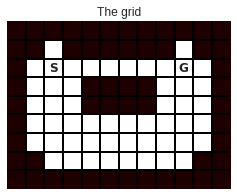

In [33]:
grid = Grid()
grid.plot_grid()


## Q1: Implement TD learning
**[5 pts]** Implement an agent that behaves randomly, but that _on-policy_ estimates state values $v(s)$, using one-step TD learning with a step size $\alpha=0.1$.

Also implement the method `get_values(self)` that returns the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement `get_values` and `step`.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  Hint: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [34]:
%%writefile randomTD.py
# don't remove the line above

class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  def get_values(self):
    return self._values

  def step(self, r, g, s):
    #Update Values
    values = self._values
    alpha = self._step_size
    prev_state = self._state
    next_state = s

    values[prev_state] =  values[prev_state] + alpha*(r + g*values[next_state] - values[prev_state])
    self._values =  values
    self._state = next_state
    #Select Action
    next_action = np.random.randint(self._number_of_actions)
    return next_action

Overwriting randomTD.py


In [35]:
###############################################################
###### Execute this cell after implementing the algorithm #####
######### in the previous cell. Don't modify this cell ########
###############################################################
print('**Q1: TD')
print('[5 pts]')
f = open('randomTD.py')
q_string = ''.join(f.readlines())
exec(compile(q_string, 'td', 'exec'))
print(q_string)
f.close()

**Q1: TD
[5 pts]
# don't remove the line above

class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  def get_values(self):
    return self._values

  def step(self, r, g, s):
    #Update Values
    values = self._values
    alpha = self._step_size
    prev_state = self._state
    next_state = s

    values[prev_state] =  values[prev_state] + alpha*(r + g*values[next_state] - values[prev_state])
    self._values =  values
    self._state = next_state
    #Select Action
    next_action = np.random.randint(self._number_of_actions)
    return next_action


### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

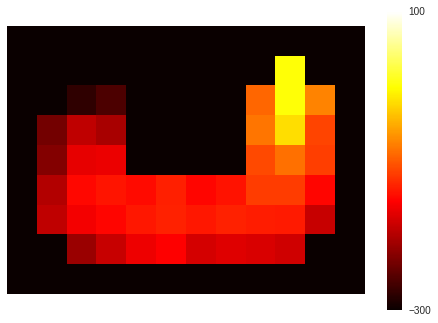

In [36]:
# DO NOT MODIFY THIS CELL
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.get_values()
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Q2: Policy iteration
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following questions.

**[5 pts]** The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

The optimal policy will go right directly towards the goal the states for which have been evaluated very lowly by the random policy evaluation. This is because the negative reward received for the very probable walking into the wall on this route overshadows the speedy reaching of the goal. A greedy policy improvement with respect to these action values will take the long route around the bottom which is the route that would be exactly correct if the model were the true model.


## Q3: Implement a general Q-learning agent
**[20 pts]** Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to update action values according to any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```
and $\epsilon$-greedy can be implemented using the `epsilon_greedy` helper function:
```
def behaviour_policy(action_values):
  return epsilon_greedy(action_values, epsilon=0.1)
```

The target policy is defined by a function `target_policy(action_values, action)`, which should return **a vector** with one probability per action.  The `action` argument is used to be able to do Sarsa: in addition to the action values, the function will also get the action as selected by the behaviour so that it can return a one hot vector for just the selected action in the Sarsa case.  So, the target policy for Sarsa would look like this:
```
def one_hot(index, max_index):
  # returns a vector of length `max_index` with zeros in all elements,
  # except the element at position `index`, which is equal to one.
  np.eye(max_index)[index]

def target_policy(action_values, action):
  return one_hot(action)
```
As another example, a random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

**Note**: the following agent interface is *sufficient* to instantiate any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**:

*   `__init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1)`

*   `step(self, reward, discount, next_state)`

We will mostly use `step_size=0.1`, so make that the default, but allow it to change when it is fed in as an argument.


In [37]:
%%writefile general_q.py
# don't remove the line above

class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._last_action = 0  # The very first action is always 0 (=up) in our setup.
    
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q

  def step(self, r, g, s):
    #Update Values
    q = self._q
    alpha = self._step_size
    prev_state = self._s
    next_state = s
    prev_action = self._last_action
      
    
    behaviour_policy = self._behaviour_policy
    target_policy = self._target_policy
    
    action = behaviour_policy(q[prev_state, :])
    target = target_policy(q[prev_state, :], action)
    
    double = self._double
    if double:
      q2 = self._q2
      target2 = target_policy(q2[prev_state, :], action)
      q[prev_state, prev_action] =  q[prev_state, prev_action] + alpha*(r + g*q2[next_state, np.argmax(np.random.multinomial(1, target))] - q[prev_state, prev_action])
      q2[prev_state, prev_action] =  q2[prev_state, prev_action] + alpha*(r + g*q[next_state, np.argmax(np.random.multinomial(1, target2))] - q2[prev_state, prev_action])
      self._q2 = q2
    else:
      q[prev_state, prev_action] =  q[prev_state, prev_action] + alpha*(r + g*q[next_state, np.argmax(np.random.multinomial(1, target))] - q[prev_state, prev_action])

    self._q =  q
    self._s = next_state
    self._last_action = action
    ##############################################################
    ### REMOVE THE RUNTIME ERROR ABOVE AND IMPLEMENT STEP HERE ###
    ##############################################################
    return action
    


Overwriting general_q.py


In [38]:
###############################################################
###### Execute this cell after implementing the algorithm #####
######### in the previous cell. Don't modify this cell ########
###############################################################
print('**Q3: General Q')
print('[10 pts]')
f = open('general_q.py')
q_string = ''.join(f.readlines())
exec(compile(q_string, 'q', 'exec'))
print(q_string)
f.close()

**Q3: General Q
[10 pts]
# don't remove the line above

class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._last_action = 0  # The very first action is always 0 (=up) in our setup.
    
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q

  def step(self, r, g, s):
    #Update Values
    q = self._q
    alpha = self._step_size
    prev_state = self._s
    next_state = s
    prev_action = self._last_action
      
    
    behaviour_policy = self._behav

In [0]:
# Experiment setup
epsilon = 0.25
step_size = 0.1

### Run the cells below to train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents and generate plots.

This trains the agents the Grid problem with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

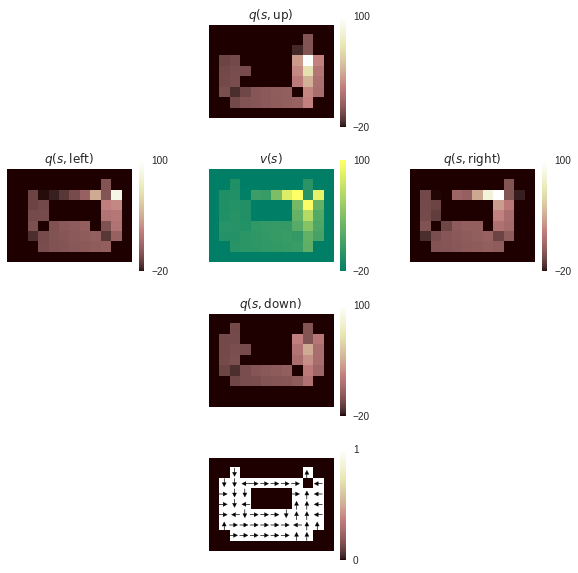

In [40]:
# Q-learning
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in xrange(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

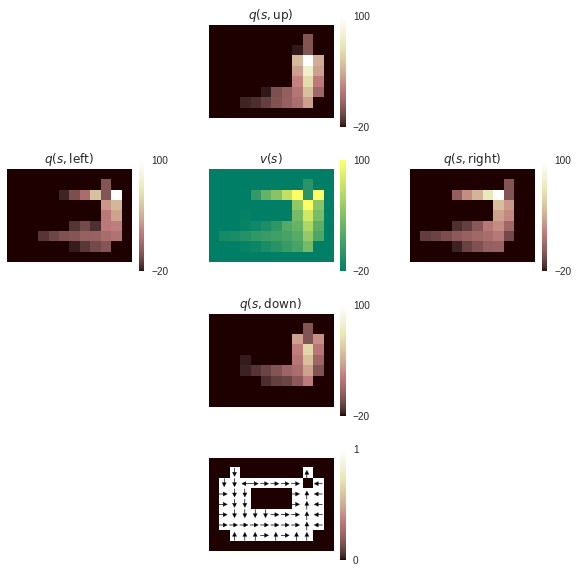

In [41]:
# Sarsa
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in xrange(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

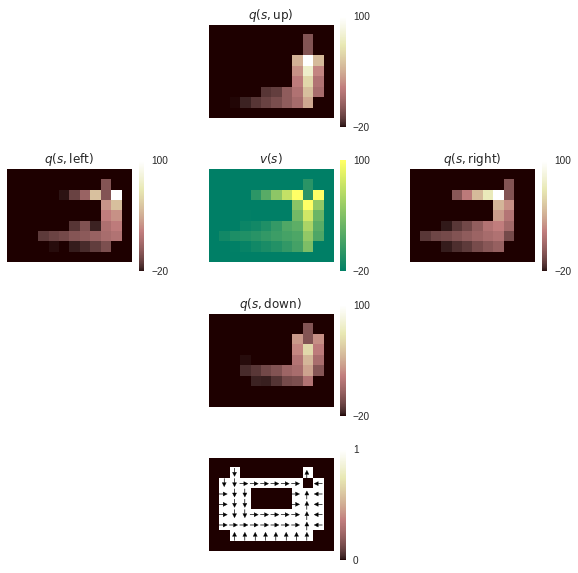

In [42]:
# Expected Sarsa
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in xrange(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

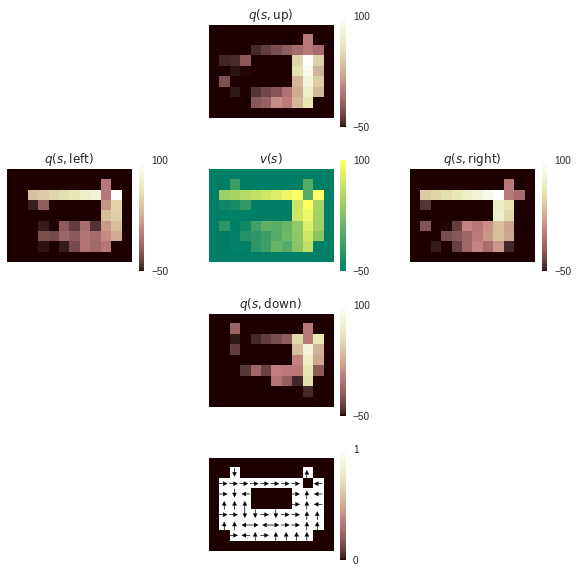

In [43]:
# double Q-learning
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon=0.1)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in xrange(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=1.)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Q4: Analyse results (Part 1)

Consider the greedy policy with respect to the estimated values learnt by each of the four agents.

**[10 pts]** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.

Off-policy algorithms have a higher chance of finding the optimum path (going right straight away)  using $\epsilon$-greedy policy since they update the state-action values with the expectation of the optimum action and so the action-values of the optimum route are less effected when exploration leads it to bump into the wall. Double Q-learning is the only one who's policy converges to the optium path in this example. Sarsa is on-policy and chooses the safest route given the $\epsilon$-greedy policy (it takes action selection into account). Q learning and expected Sarsa differ by the smoothness of nearby action values- since expected sarsa updates with the expected value of the next states action values nearby states tend to be monotonically increasing or decreasing in value (smooth) while Q-learning changes much more suddenly.

**[10 pts]** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* on average yield higher returns during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

In the GridWorld Double Q learning is expected to yield higher reward than Q learning since it will avoid taking the suboptimal paths for longer since it is not subject to maximisation bias. Sarsa is On-Policy and so will be updating it's state-action values given the actions it's taking and so will avoid dangerous routes (such as the optimal one here) because it reduces state action values that put it in a position that makes it likely to  'expolre' into the wall whereas an off-policy wouldn't. Thus Expected sarsa should perform the best if it was on-policy for the above reason with the extra advantage of being able to weight expectations rather than just maximum state-action value, however off-policy it will be below sarsa but above double Q learning and Q learning.

## Q5: Target Q-learning

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

Imagine now to train both Q-learning and target Q-learning on the Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

**[10 pts]** Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

Since q' is fixed, target Q-learning will update each action value just once. As discussed above, expected sarsa learns action values in a 'smooth' way (nearby states tend to have monotonically increasing/decreasing values)  which will act well pre-training for target Q-learning as it will allow the $\epsilon$-greedy policy to easily get back on track if it taskes a bad turn while Q-learning will take only the value of the optimum action, neglecting that it might take a suboptimal future action that will incur large negative reward.



## The second grid world

In the grid world below, the agent gets a reward of -1 on each step in the top corridor, except if it bumps into a black wall: then the reward is $-100$.

There are two versions of the domain, that differ only in terms of the rewards received in the *vertical* corridor: in the deterministic variant, when `noisy=False`, the reward there is also $-1$ per step.  In the stochastic variance, when `noisy=True`, the per step reward is either $-12$ or $+10$ with equal probability, regardless of whether the agent bump into a wall or makes another move.  In both cases, the rewards in the top corridor are deterministic (when conditioned on the agent's action).

The discount is $\gamma=1$.  Each episode ends only when the agent enters a terminal state, denoted with $\mathrm{T}$.  The agent then starts a new episode from the starting state $\mathrm{S}$.  (Equivalently, you can think of the agent transitioning to $\mathrm{S}$ instead of to $\mathrm{T}$, with a discount of $\gamma_t=0$ on that specific time step.)

When the agent bumps into one walls (darker grey or black), it stays in the same state. For instance, moving *UP* from the start state yields a reward of $-1$ and the subsequent state will be the same state. Similarly, moving *DOWN* at the bottom of the vertical corridor will yield a reward of $-12$ or $+10$, and the agent will remain in that state.

In [0]:
W = -100
X = -1
GRID2_LAYOUT = np.array([
  [W, W, W, X, X, X, X, X],
  [W, 1, 0, 0, 0, 0, 1, X],
  [W, W, X, 0, X, X, X, X],
  [W, W, X, 0, X, X, X, X],
  [W, W, X, 0, X, X, X, X],
  [W, W, X, 0, X, X, X, X],
  [W, W, X, X, X, X, X, X],
])

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class Grid2(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID2_LAYOUT
    self._start_state = (1, 3)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def step(self, action):
    y, x = self._state
    
    if action == UP:
      new_state = (y - 1, x)
    elif action == RIGHT:
      new_state = (y, x + 1)
    elif action == DOWN:
      new_state = (y + 1, x)
    elif action == LEFT:
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    discount = 1.

    if reward == W or reward == X:  # wall
      new_state = (y, x)  # bounced
    elif reward == 0:  # empty cell
      reward = -1
    else:  # a goal
      reward = 0
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      if y > 1:
        reward = np.random.choice([-12, 10])  # -1 on average, but noisy
    
    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    x = self._layout
    plt.imshow((x + np.sqrt(x**2 + 1))**0.4,  # transform for pretty plotting
               interpolation="nearest", cmap='bone')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 1, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(1, 1, r"$\mathbf{T}$", ha='center', va='center')
    plt.text(6, 1, r"$\mathbf{T}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

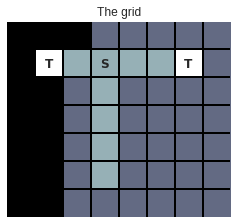

In [55]:
grid = Grid2()
grid.plot_grid()

In [0]:
# Configs
epsilon = 0.5
step_size = 0.1

### Run the cells below to train Sarsa / Expected Sarsa / Q-learning / double Q-learning on a noisy version of the grid-world.

The cell below will run 10 repetitions of each experiment corresponding to all combinations of algorithm and environment, for the four algorithms named above and for the two variants of the grid world (with, and without noisy rewards in the vertical corridor).

In [0]:
# Policies.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

def greedy(q):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

q_target_policy = lambda q, _: greedy(q)

def sarsa_target_policy(q, a):
  return np.eye(len(q))[a]

def expected_sarsa_target_policy(q, _):
  return (1 - epsilon)*greedy(q) + epsilon/len(q) 

plt_num = 0
fig = plt.figure(figsize=(10, 9))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

  
for noisy in [False, True]:
  mean_rewards = dict(
      q_learning=[],
      double_q_learning=[],
      sarsa = [],
      expected_sarsa = [])

  final_rewards = dict(
      q_learning=[],
      double_q_learning=[],
      sarsa = [],
      expected_sarsa = [])

  from functools import partial
  agent_fn = partial(GeneralQ,
                     number_of_states=grid._layout.size,
                     number_of_actions=4,
                     initial_state=grid.get_obs(),
                     behaviour_policy=behaviour_policy,
                     step_size=step_size)
  for _ in range(20):
    # Instantiate all 4 agents.
    agents = dict(
      q_learning=agent_fn(target_policy=q_target_policy, double=False),
      sarsa=agent_fn(target_policy=sarsa_target_policy, double=False),
      expected_sarsa=agent_fn(target_policy=expected_sarsa_target_policy, double=False),
      double_q_learning=agent_fn(target_policy=q_target_policy, double=True),
    )

    # Run an experiment with each of the agents.
    for name, agent in agents.items():
      grid = Grid2(noisy=noisy)
      mean_rewards[name].append(run_experiment(grid, agent, int(1e4)))

      # evaluate greedy policy
      agent._behaviour_policy = lambda q: np.argmax(q)
      agent._step_size = 0.
      final_rewards[name].append(run_experiment(grid, agent, int(1e4)))  


  # Plot performance across runs.
  for rewards, label in [(mean_rewards, "average reward during learning\nnoisy rewards: {}".format(noisy)),
                         (final_rewards, "reward of greedy policy after learning\nnoisy rewards: {}".format(noisy))]:
    plt_num += 1
    plt.subplot(2, 2, plt_num)
    plt.boxplot([
        rewards[alg] for alg in
        ["q_learning", "sarsa", "expected_sarsa", "double_q_learning"]
    ])
    plt.xticks([1, 2, 3, 4], ["Q-learning", "Sarsa", "Expected Sarsa", "Double Q-learning"], rotation=60, size=12, ha='right')
    plt.ylabel(label, size=12)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(0)
    
plt.tight_layout()

## Q6: Analyse results (Part 2)

The plots above show 
 * **left column**: the distributions of average rewards per step over all learning steps (i.e., a single number per experiment) over 20 experiments per algorithm,
 * **right column**: the distributions of average rewards per step when executing the greedy policy after learning over 20 experiments per algorithm,

and

 * **top row**: when the rewards are deterministic: $r=-1$ per step, expect when bumping into a black wall: $r=-100$, and except on termination: $r=0$,
 * **bottom row**: when the rewards in the vertical corridor are randomly either $r=-12$ or $r=+10$, with equal probability.
 
 Answer the questions below.   Be complete, but concise.  Remember that points can be deducted for irrelevant or false statements, even if the answer also includes all of the true statements we were looking for.

**[16 pts]** Look at the top row.  Note which two algorithms performed best during learning (left), and which two performed best after learning (right).  How and why does the performance differ, and how is it the same, between the left and right plots? Explain the observed performances for all eight experiments in the top row, and explicitly contrast and explain notable observed differences.

> *Answer here*

**[12 pts]** Compare all the results in the top row with the results in the bottom row.  For all eight experiments in the bottom row, explain the observed performance, and mention explicitly why the performance is notably different or why it is the same as in the top row.

> *Answer here*

**[12 pts]** Suppose we run the same experiments with a fixed step size of $\alpha=1$. You can ignore double Q-learning for this question.  For each of the other three algorithms, Q-learning, Sarsa, and Expected Sarsa, what would happen in both the deterministic and the noisy domain?  For each of the six combinations of algorithm and domain, briefly describe how the action values behave when we would run the experiments for a very long time (so you can ignore any effects that only matter at the beginning of learning, such as the initial value estimates).

> *Answer here*

In [0]:
# fin